In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Features  extraction

In [2]:
import os
import numpy as np
from skimage import io
from skimage.util import view_as_windows
import matplotlib.pyplot as plt


# Function to extract 7x7 patch features from the images
def extract_features(image, patch_size=(7, 7), shift=1):
    # Extract overlapping patches from the image
    patches = view_as_windows(image, patch_size, step=shift)
    # Reshape patches to (num_patches, patch_height, patch_width)
    patches = patches.reshape(-1, patch_size[0], patch_size[1])
    # Compute mean and std for each patch
    features = np.array([[np.mean(patch), np.std(patch)] for patch in patches])
    return features

# Function to process images in a folder and extract features
def process_image_dataset(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):  # Assuming images are in PNG format
            image_path = os.path.join(input_folder, filename)
            image = io.imread(image_path, as_gray=True)  # Load image as grayscale
            features = extract_features(image)
            output_path = os.path.join(output_folder, f"{filename}_features.npy")
            np.save(output_path, features)
            print(f"Saved features for {filename} to {output_path}")


# Function to ensure the correct file extension
def ensure_png_extension(filename):
    if not filename.endswith(".png"):
        return f"{filename}.png"
    return filename


# Set the paths for the training and test datasets
train_images_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/Train'  # Set your path
test_images_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/Test'    # Set your path
train_output_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_train_feature'
test_output_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_test_feature'

# Step 1: Extract features from training and test images
print("Extracting features from training images...")
process_image_dataset(train_images_folder, train_output_folder)

print("Extracting features from test images...")
process_image_dataset(test_images_folder, test_output_folder)



Extracting features from training images...
Saved features for 134.png to /content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_train_featuret/134.png_features.npy
Saved features for 123.png to /content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_train_featuret/123.png_features.npy
Saved features for 133.png to /content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_train_featuret/133.png_features.npy
Saved features for 128.png to /content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_train_featuret/128.png_features.npy


KeyboardInterrupt: 

# K-Means Clustering


Training custom K-Means clustering model on training features (Euclidean distance)...
Initialize  Cluster Centers for K-Means:
[[229.73469388   2.96768659]
 [199.67346939   5.74060992]
 [183.06122449   6.61293773]]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


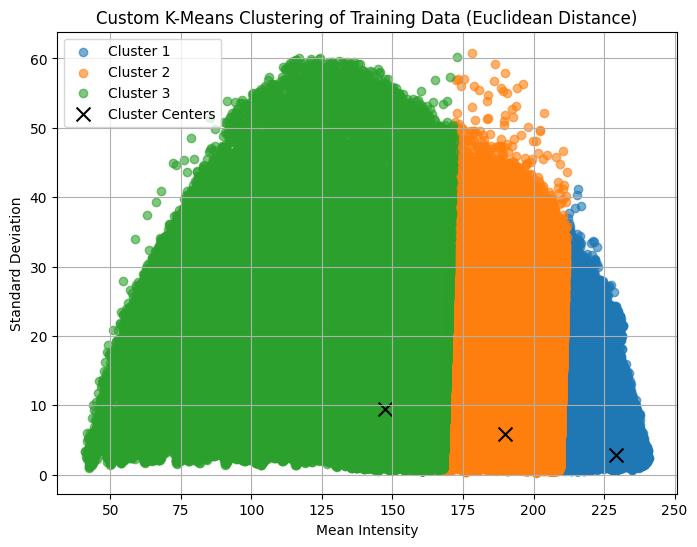

Cluster 1: Mean = [229.21356684   2.82034981], Standard Deviation = [3.56318741 2.41285746]
Cluster 2: Mean = [189.74493425   5.852593  ], Standard Deviation = [11.20152377  5.24380692]
Cluster 3: Mean = [147.18572802   9.40895873], Standard Deviation = [20.97051113  8.51744238]
Segmenting test images using the custom K-Means model (Euclidean distance)...


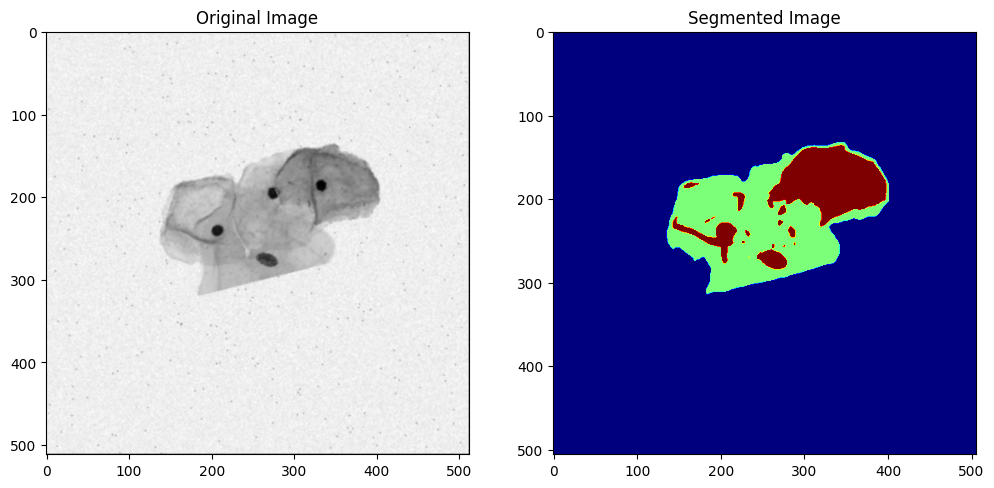

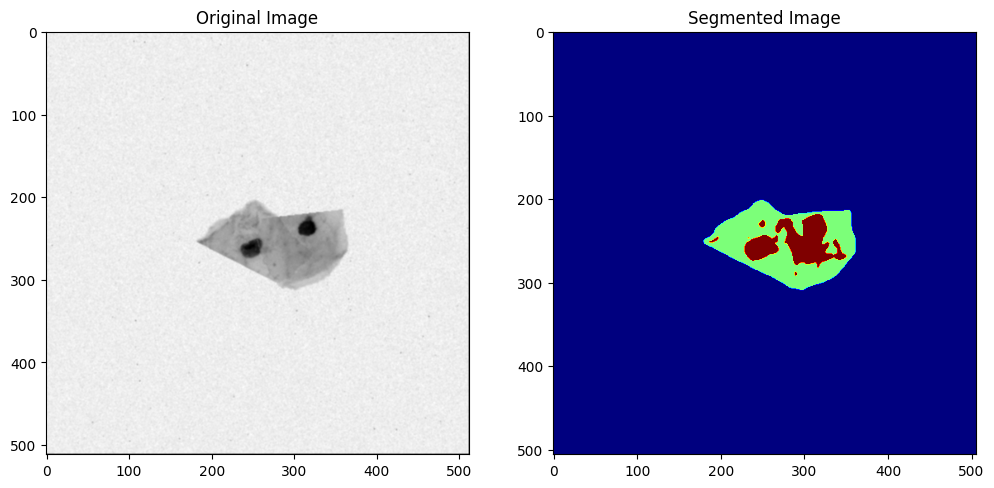

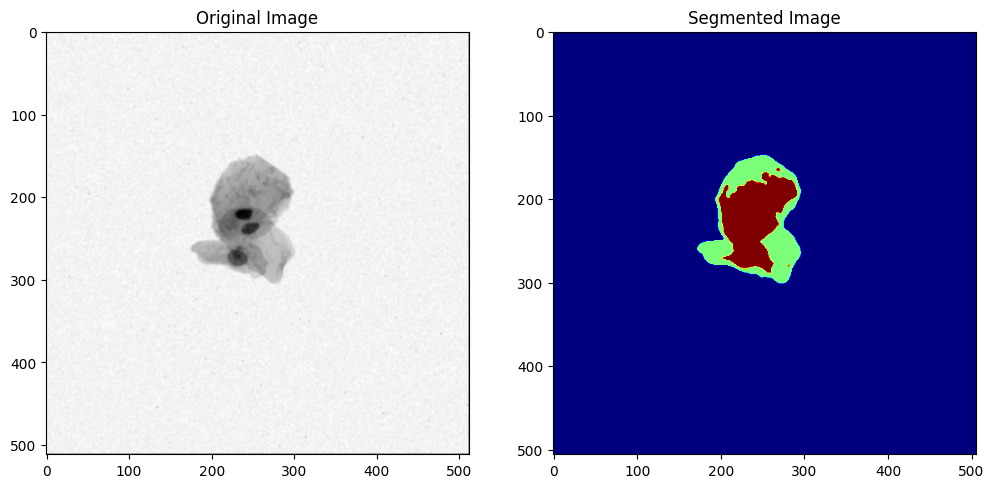

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
# Function to calculate the number of patches (grid) based on the image size
def calculate_patch_grid(image_shape, patch_size=(7, 7), shift=1):
    return (
        (image_shape[0] - patch_size[0]) // shift + 1,
        (image_shape[1] - patch_size[1]) // shift + 1
    )

# Function to display original and segmented images side by side
def display_segmentation_results(image, segmented_image):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(segmented_image, cmap='jet')
    ax[1].set_title('Segmented Image')
    plt.show()

# Function to ensure the correct file extension
def ensure_png_extension(filename):
    if not filename.endswith(".png"):
        return f"{filename}.png"
    return filename

# Custom K-Means function (without libraries)
def kmeans_clustering(features, n_clusters=3, max_iters=100, tol=1e-4):
    # Randomly initialize cluster centers from the features
    np.random.seed(42)  # For reproducibility
    centers = features[np.random.choice(features.shape[0], n_clusters, replace=False)]
    global initial_cluster_centers_for_Modified_k_Means
    initial_cluster_centers_for_Modified_k_Means = centers  # store the initialize centers for k modified clustering
    print("Initialize  Cluster Centers for K-Means:")
    print(centers)
    for iteration in range(max_iters):
        # Step 1: Assign points to the nearest cluster center
        distances = np.linalg.norm(features[:, np.newaxis] - centers, axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 2: Recompute cluster centers as the mean of points in each cluster
        new_centers = np.array([features[labels == i].mean(axis=0) for i in range(n_clusters)])

        # Step 3: Check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break

        centers = new_centers

    return labels, centers

# Function to plot the clusters on the training data
def plot_kmeans_clusters(features, labels, centers):
    plt.figure(figsize=(8, 6))

    # Plot each cluster with a different color
    for i in range(centers.shape[0]):
        cluster_points = features[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}", alpha=0.6)

    # Plot the cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='x', s=100, label="Cluster Centers")

    plt.title("Custom K-Means Clustering of Training Data (Euclidean Distance)")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Standard Deviation")
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final mean and standard deviation of each cluster
def print_cluster_stats(features, labels, n_clusters):
    for i in range(n_clusters):
        cluster_points = features[labels == i]
        cluster_mean = cluster_points.mean(axis=0)
        cluster_std = cluster_points.std(axis=0)
        print(f"Cluster {i+1}: Mean = {cluster_mean}, Standard Deviation = {cluster_std}")

# Function to perform segmentation on test images using the custom K-Means model
def segment_test_image_using_kmeans(test_feature_folder, cluster_centers, original_images_folder, labels, patch_size=(7, 7), shift=1):
    for filename in os.listdir(test_feature_folder):
        if filename.endswith("_features.npy"):
            feature_path = os.path.join(test_feature_folder, filename)
            image_features = np.load(feature_path)

            # Perform clustering on test image features (without library)
            distances = np.linalg.norm(image_features[:, np.newaxis] - cluster_centers, axis=2)
            test_labels = np.argmin(distances, axis=1)

            # Load the original image to determine its shape
            original_image_filename = filename.replace('_features.npy', '')
            original_image_filename = ensure_png_extension(original_image_filename)
            original_image_path = os.path.join(original_images_folder, original_image_filename)

            if not os.path.exists(original_image_path):
                print(f"File not found: {original_image_path}")
                continue

            original_image = io.imread(original_image_path, as_gray=True)
            image_shape = original_image.shape

            # Reshape the labels to match the patch grid shape of the original image
            patch_grid_shape = calculate_patch_grid(image_shape, patch_size, shift)
            segmented_image = test_labels.reshape(patch_grid_shape)

            # Display results
            display_segmentation_results(original_image, segmented_image)

# Function to train K-Means clustering (Euclidean distance) and obtain initial cluster centers
def train_kmeans_clustering_euclidean(train_feature_folder, n_clusters=3):
    # Load all training features
    all_train_features = []
    for filename in os.listdir(train_feature_folder):
        if filename.endswith("_features.npy"):
            feature_path = os.path.join(train_feature_folder, filename)
            features = np.load(feature_path)
            all_train_features.append(features)

    all_train_features = np.vstack(all_train_features)  # Combine all training features into one array

    # Perform custom K-Means clustering
    labels, centers = kmeans_clustering(all_train_features, n_clusters=n_clusters)

    # Plot the training features and cluster assignments
    plot_kmeans_clusters(all_train_features, labels, centers)

    # Print the final mean and standard deviation for each cluster
    print_cluster_stats(all_train_features, labels, n_clusters)

    return centers, labels

# Set the paths for the training and test datasets
train_output_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_train_feature'  # Path where train features are stored
test_output_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_test_feature'    # Path where test features are stored
test_images_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/Test'                  # Path to the original test images

# Step 1: Perform custom K-Means clustering to get initial centers
print("Training custom K-Means clustering model on training features (Euclidean distance)...")
initial_cluster_centers, kmeans_labels = train_kmeans_clustering_euclidean(train_output_folder)
# Step 2: Perform segmentation on test images using the custom K-Means model
print("Segmenting test images using the custom K-Means model (Euclidean distance)...")
segment_test_image_using_kmeans(test_output_folder, initial_cluster_centers, test_images_folder, kmeans_labels)


# Modified K-Means Clustering


Training K-Means clustering model with Mahalanobis distance on training features...
Initialize Cluster Centers for Modified K-Means:
[[229.73469388   2.96768659]
 [199.67346939   5.74060992]
 [183.06122449   6.61293773]]


<ipython-input-14-1ce4439f715a>:141: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


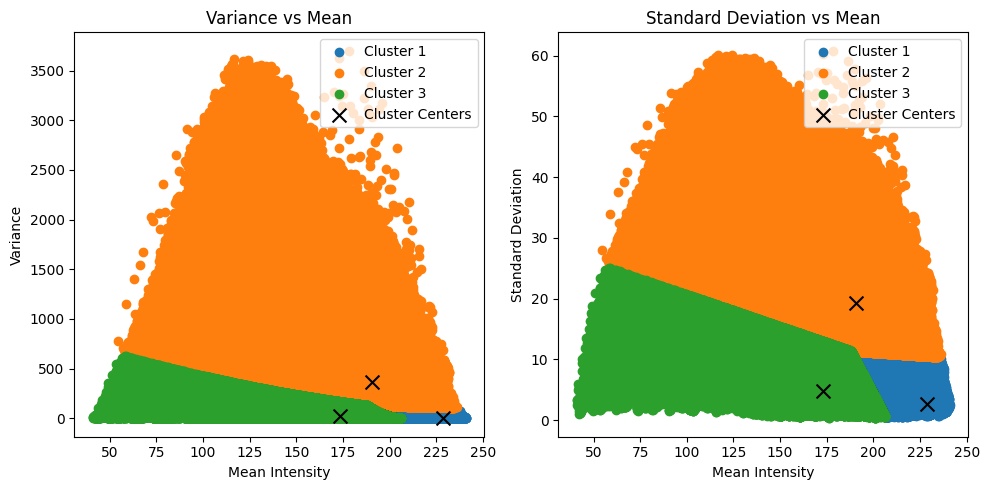

Cluster 1: Mean = [228.66478029   2.58836079], Standard Deviation = [5.4435961  1.25455963]
Cluster 2: Mean = [190.63913146  19.23996282], Standard Deviation = [33.12821184  6.42819484]
Cluster 3: Mean = [173.25358485   4.78206656], Standard Deviation = [22.77650395  3.00042012]
Segmenting test images using the modified K-Means (Mahalanobis distance) model...


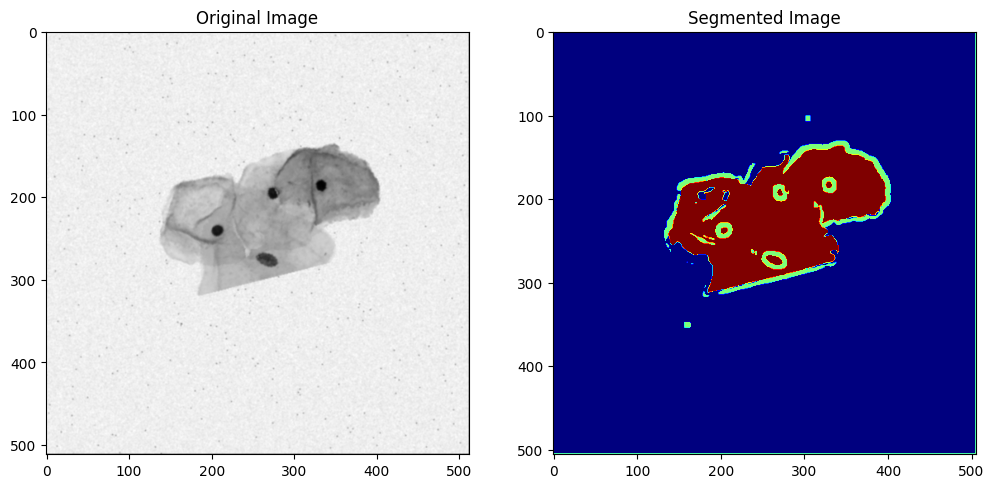

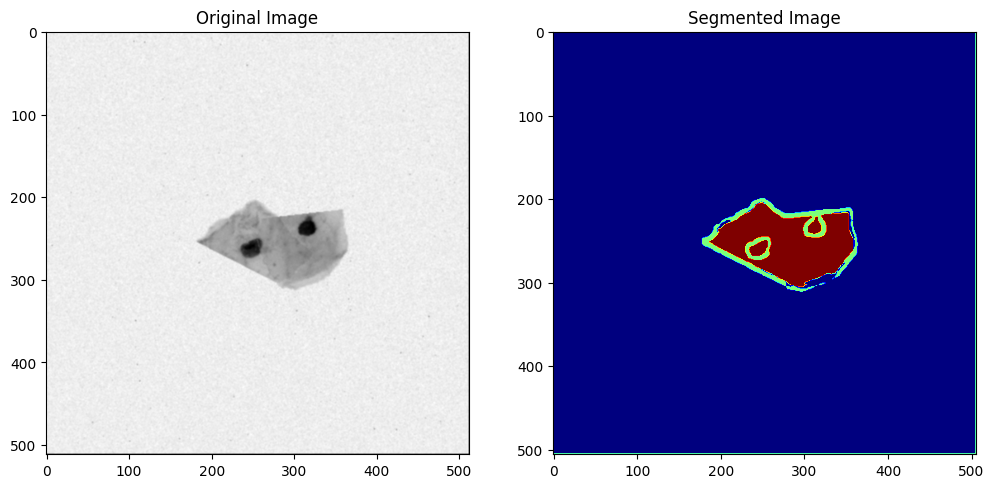

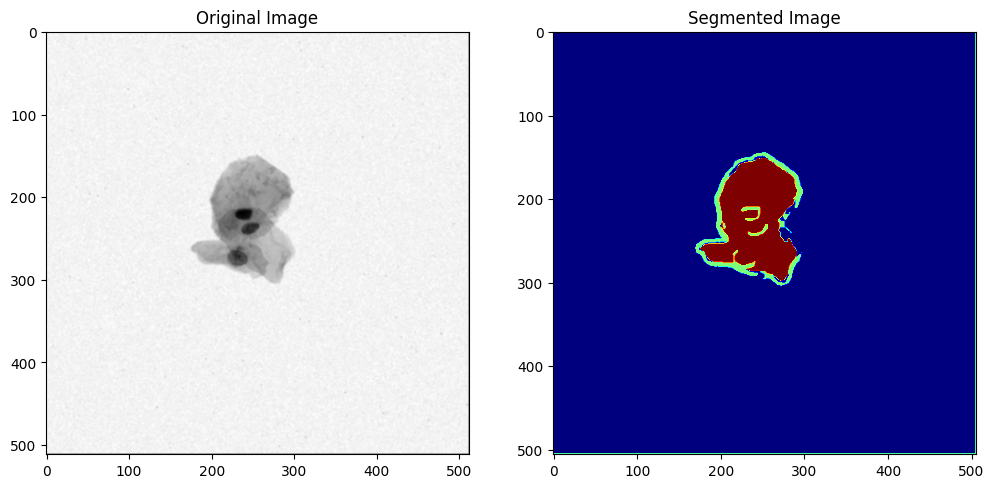

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io


# Function to calculate Mahalanobis distance between points and cluster centers
def mahalanobis_distance(features, cluster_centers):
    # Compute the covariance matrix of the features and its inverse
    covariance_matrix = np.cov(features.T)
    inv_cov_matrix = np.linalg.inv(covariance_matrix)

    # Compute Mahalanobis distance between each feature and each cluster center
    distances = []
    for feature in features:
        distances.append([np.sqrt((feature - center).T @ inv_cov_matrix @ (feature - center)) for center in cluster_centers])
    return np.array(distances)

# Manually implemented K-Means using Mahalanobis distance
def modified_kmeans_mahalanobis(features, initial_cluster_centers, n_clusters=3, max_iters=100, tol=1e-4):
    cluster_centers = initial_cluster_centers  # Start with the same initial centers
    for iteration in range(max_iters):
        # Step 1: Compute Mahalanobis distance between features and cluster centers
        distances = mahalanobis_distance(features, cluster_centers)

        # Step 2: Assign each point to the nearest cluster center
        labels = np.argmin(distances, axis=1)

        # Step 3: Recompute cluster centers based on current assignments
        new_cluster_centers = np.array([features[labels == i].mean(axis=0) for i in range(n_clusters)])

        # Step 4: Check for convergence (if the cluster centers don't change much)
        if np.linalg.norm(new_cluster_centers - cluster_centers) < tol:
            break

        # Update cluster centers
        cluster_centers = new_cluster_centers

    return labels, cluster_centers

# Function to display original and segmented images side by side
def display_segmentation_results(image, segmented_image):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(segmented_image, cmap='jet')
    ax[1].set_title('Segmented Image')
    plt.show()

# Function to ensure the correct file extension
def ensure_png_extension(filename):
    if not filename.endswith(".png"):
        return f"{filename}.png"
    return filename

# Function to perform segmentation on test images using the trained Mahalanobis-based K-Means model
def segment_test_image_using_modified_kmeans(test_feature_folder, cluster_centers, original_images_folder, patch_size=(7, 7), shift=1):
    for filename in os.listdir(test_feature_folder):
        if filename.endswith("_features.npy"):
            feature_path = os.path.join(test_feature_folder, filename)
            image_features = np.load(feature_path)

            # Perform Mahalanobis-based K-Means clustering on test image features
            labels, _ = modified_kmeans_mahalanobis(image_features, cluster_centers)

            # Load the original image to determine its shape
            original_image_filename = filename.replace('_features.npy', '')
            original_image_filename = ensure_png_extension(original_image_filename)
            original_image_path = os.path.join(original_images_folder, original_image_filename)

            if not os.path.exists(original_image_path):
                print(f"File not found: {original_image_path}")
                continue

            original_image = io.imread(original_image_path, as_gray=True)
            image_shape = original_image.shape

            # Reshape the labels to match the patch grid shape of the original image
            patch_grid_shape = ((image_shape[0] - patch_size[0]) // shift + 1,
                                (image_shape[1] - patch_size[1]) // shift + 1)
            segmented_image = labels.reshape(patch_grid_shape)

            # Display results
            display_segmentation_results(original_image, segmented_image)

# Manually implemented K-Means with Mahalanobis distance (instead of Euclidean distance)
def manual_kmeans_mahalanobis(features, n_clusters=3, max_iters=100, tol=1e-4):
    # Initialize cluster centers initialize same  as K- means clustering
                                                                                                              # random_indices = np.random.choice(features.shape[0], n_clusters, replace=False)
    cluster_centers = initial_cluster_centers_for_Modified_k_Means                                                                             #features[random_indices]
    print("Initialize Cluster Centers for Modified K-Means:")
    print(cluster_centers)
    for iteration in range(max_iters):
        # Step 1: Calculate Mahalanobis distance between each feature and the cluster centers
        distances = mahalanobis_distance(features, cluster_centers)

        # Step 2: Assign each feature to the nearest cluster
        labels = np.argmin(distances, axis=1)

        # Step 3: Update cluster centers
        new_cluster_centers = np.array([features[labels == i].mean(axis=0) for i in range(n_clusters)])

        # Step 4: Check for convergence
        if np.linalg.norm(new_cluster_centers - cluster_centers) < tol:
            break

        # Update cluster centers
        cluster_centers = new_cluster_centers

    return labels, cluster_centers

# Function to plot the clusters on training data (variance vs mean and std dev vs mean)
def plot_kmeans_clusters(features, labels, centers):
    mean = features[:, 0]
    std_dev = features[:, 1]
    variance = std_dev ** 2  # Variance is the square of standard deviation

    # Plot variance vs mean
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    for i in range(centers.shape[0]):
        cluster_points = features[labels == i]
        plt.scatter(cluster_points[:, 0], (cluster_points[:, 1]**2), label=f"Cluster {i+1}")
    plt.scatter(centers[:, 0], centers[:, 1]**2, color='black', marker='x', s=100, label="Cluster Centers")
    plt.title("Variance vs Mean")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Variance")
    plt.legend()

    # Plot standard deviation vs mean
    plt.subplot(1, 2, 2)
    for i in range(centers.shape[0]):
        cluster_points = features[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}")
    plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='x', s=100, label="Cluster Centers")
    plt.title("Standard Deviation vs Mean")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Standard Deviation")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to train K-Means clustering (using Mahalanobis distance) and print the final results
def train_kmeans_clustering_manual_mahalanobis(train_feature_folder, n_clusters=3):
    # Load all training features
    all_train_features = []
    for filename in os.listdir(train_feature_folder):
        if filename.endswith("_features.npy"):
            feature_path = os.path.join(train_feature_folder, filename)
            features = np.load(feature_path)
            all_train_features.append(features)

    all_train_features = np.vstack(all_train_features)  # Combine all training features into one array

    # Perform K-Means clustering using Mahalanobis distance
    labels, cluster_centers = manual_kmeans_mahalanobis(all_train_features, n_clusters)

    # Plot the training features and cluster assignments
    plot_kmeans_clusters(all_train_features, labels, cluster_centers)

    # Print the final mean and standard deviation for each cluster
    for i in range(n_clusters):
        cluster_points = all_train_features[labels == i]
        cluster_mean = cluster_points.mean(axis=0)
        cluster_std = cluster_points.std(axis=0)
        print(f"Cluster {i+1}: Mean = {cluster_mean}, Standard Deviation = {cluster_std}")

    return cluster_centers

# Set the paths for the training and test datasets
train_output_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_train_feature'  # Path where train features are stored
test_output_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/output_test_feature'    # Path where test features are stored
test_images_folder = r'/content/drive/MyDrive/SPR ASSIGNMENT/SPR_ASSIGNMENT2/Assgiment2/cervical_cytology_cell_Image_dataset/Test'                  # Path to the original test images

# Step 1: Perform manual K-Means clustering using Mahalanobis distance to get initial centers
print("Training K-Means clustering model with Mahalanobis distance on training features...")
initial_cluster_centers = train_kmeans_clustering_manual_mahalanobis(train_output_folder)

# Step 2: Perform segmentation on test images using modified K-Means with Mahalanobis distance
print("Segmenting test images using the modified K-Means (Mahalanobis distance) model...")
segment_test_image_using_modified_kmeans(test_output_folder, initial_cluster_centers, test_images_folder)
